In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import xgboost as xgb

In [2]:
# Download stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\anshul
[nltk_data]     dubey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Download WordNet (lexical database for English language)
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\anshul
[nltk_data]     dubey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
## Reading data from csv file
df = pd.read_csv("Rating_Scrapping_data.csv")
df.head()

,Unnamed: 0,Product_Review,Ratings
0,0,"After buying this headphone, the seller delive...",4.0
1,1,यह अत्यंत प्रभावशाली है इसकी saund quality भी ...,4.0
2,2,NaN,4.0
3,3,This is an amazing pair of headphones i got th...,4.0
4,4,I really like the headphones. Its of great val...,4.0


In [5]:
## Dropping unnecessary column Unnamed
df.drop('Unnamed: 0',axis =1, inplace = True)

In [6]:
df.shape

(64410, 2)

In [7]:
## Checking data type
df.dtypes

Product_Review     object
Ratings           float64
dtype: object

In [8]:
## Checking value count for Ratings column:
df['Ratings'].value_counts()

4.0    48538
5.0    10237
3.0     3618
1.0     1460
2.0      550
Name: Ratings, dtype: int64

In [9]:
## Checking meta data:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64410 entries, 0 to 64409
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Product_Review  63753 non-null  object 
 1   Ratings         64403 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1006.5+ KB


In [10]:
## Checking missing/Null values:
df.isnull().sum()

Product_Review    657
Ratings             7
dtype: int64

In [11]:
df['Product_Review'].fillna('Review Not Available',inplace=True)
df['Ratings'].fillna('Ratings',inplace=True)

In [12]:
## Again Checking missing/Null values:
df.isnull().sum()

Product_Review    0
Ratings           0
dtype: int64

<AxesSubplot:xlabel='Ratings', ylabel='count'>

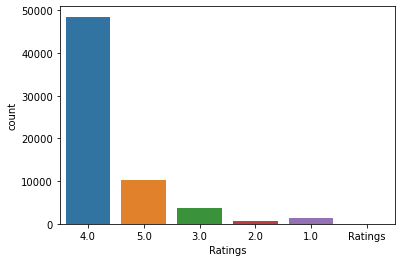

In [14]:
# Let's see how our Target column is distributed
import seaborn as sns
sns.countplot('Ratings',data=df)

In [18]:
df['Product_Review'] = df.Product_Review.str.lower()


In [20]:
cols=['Product_Review']
for j in cols:
    # Replace email addresses with 'email'
    df[j] = df[j].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                     'emailaddress')

    # Replace URLs with 'webaddress'
    df[j] = df[j].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                      'webaddress')

    # Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
    df[j] = df[j].str.replace(r'£|\$', 'dollers')

    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    df[j] = df[j].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                      'phonenumber')


    # Replace numbers with 'numbr'
    df[j] = df[j].str.replace(r'\d+(\.\d+)?', 'numbr')

    # Remove punctuation
    df[j] = df[j].str.replace(r'[^\w\d\s]', ' ')

    # Replace whitespace between terms with a single space
    df[j] = df[j].str.replace(r'\s+', ' ')

    # Remove leading and trailing whitespace
    df[j] = df[j].str.replace(r'^\s+|\s+?$', '')

C:\Users\ANSHUL~1\AppData\Local\Temp/ipykernel_25588/3029745825.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[j] = df[j].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
C:\Users\ANSHUL~1\AppData\Local\Temp/ipykernel_25588/3029745825.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df[j] = df[j].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
C:\Users\ANSHUL~1\AppData\Local\Temp/ipykernel_25588/3029745825.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df[j] = df[j].str.replace(r'£|\$', 'dollers')
C:\Users\ANSHUL~1\AppData\Local\Temp/ipykernel_25588/3029745825.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df[j] = df[j].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
C:\Users\ANSHUL~1\AppData\Local\Temp/ipykernel_25588/3029745825.py:20: FutureWarnin

In [21]:
df.head()

,Product_Review,Ratings
0,after buying this headphone the seller deliver...,4.0
1,यह अत य त प रभ वश ल ह इसक saund quality भ उत त...,4.0
2,review not available,4.0
3,this is an amazing pair of headphones i got th...,4.0
4,i really like the headphones its of great valu...,4.0


In [22]:
# Remove stopwords
import string
import nltk
from nltk.corpus import  stopwords

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

df['Product_Review'] = df['Product_Review'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

In [23]:
from nltk.tokenize import RegexpTokenizer
tokenizer=RegexpTokenizer(r'\w+')
df['Product_Review'] = df['Product_Review'].apply(lambda x: tokenizer.tokenize(x.lower()))
df.head()

,Product_Review,Ratings
0,"[buying, headphone, seller, delivered, refurbi...",4.0
1,"[यह, अत, य, त, प, रभ, वश, ल, ह, इसक, saund, qu...",4.0
2,"[review, available]",4.0
3,"[amazing, pair, headphones, got, numbr, worth,...",4.0
4,"[really, like, headphones, great, value, price...",4.0


In [24]:
# writing function for the entire dataset
# Lemmatizing and then Stemming with Snowball to get root words and further reducing characters

from nltk.stem import SnowballStemmer, WordNetLemmatizer
stemmer = SnowballStemmer("english")
import gensim
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='v'))

#Tokenize and Lemmatize
def preprocess(text):
    result=[]
    for token in text:
        if len(token)>=3:
            result.append(lemmatize_stemming(token))
            
    return result

In [28]:
# Processing review with above Function
processed_review = []

for doc in df.Product_Review:
    processed_review.append(preprocess(doc))
    
print(len(processed_review))
processed_review[:3]

64410


[['buy',
  'headphon',
  'seller',
  'deliv',
  'refurbish',
  'alreadi',
  'use',
  'product',
  'headset',
  'wors',
  'rang',
  'right',
  'side',
  'speaker',
  'faulti',
  'pleas',
  'make',
  'sure',
  'test',
  'product',
  'thorough',
  'within',
  'replac',
  'durat',
  'set',
  'amazon',
  'product',
  'good',
  'enough',
  'price',
  'rang',
  'speaker',
  'pretti',
  'good',
  'bass',
  'fine',
  'well',
  'go',
  'rang',
  'plan',
  'game',
  'special',
  'sound',
  'pretti',
  'muffl',
  'numbrd',
  'surround',
  'non',
  'exist',
  'build',
  'qualiti',
  'good',
  'larger',
  'head',
  'tight',
  'like',
  'tight',
  'option',
  'buy',
  'headset',
  'mic',
  'first',
  'time',
  'let',
  'warn',
  'cant',
  'use',
  'mic',
  'listen',
  'sound',
  'time',
  'headset',
  'use',
  'numbr',
  'somewhat',
  'outdat',
  'consid',
  'today',
  'standard',
  'basic',
  'either',
  'receiv',
  'input',
  'music',
  'listen',
  'transmit',
  'output',
  'voic',
  'mic',
  'anot

In [29]:
df['clean_review']=processed_review

In [30]:
df.head()

,Product_Review,Ratings,clean_review
0,"[buying, headphone, seller, delivered, refurbi...",4.0,"[buy, headphon, seller, deliv, refurbish, alre..."
1,"[यह, अत, य, त, प, रभ, वश, ल, ह, इसक, saund, qu...",4.0,"[इसक, saund, qualiti, camfort, water, resist, ..."
2,"[review, available]",4.0,"[review, avail]"
3,"[amazing, pair, headphones, got, numbr, worth,...",4.0,"[amaz, pair, headphon, get, numbr, worth, pric..."
4,"[really, like, headphones, great, value, price...",4.0,"[realli, like, headphon, great, valu, price, q..."


In [31]:
df['Product_Review'] = df['clean_review'].apply(lambda x:' '.join(y for y in x))

In [32]:
df.head()

,Product_Review,Ratings,clean_review
0,buy headphon seller deliv refurbish alreadi us...,4.0,"[buy, headphon, seller, deliv, refurbish, alre..."
1,इसक saund qualiti camfort water resist nois ca...,4.0,"[इसक, saund, qualiti, camfort, water, resist, ..."
2,review avail,4.0,"[review, avail]"
3,amaz pair headphon get numbr worth price excep...,4.0,"[amaz, pair, headphon, get, numbr, worth, pric..."
4,realli like headphon great valu price quantiti...,4.0,"[realli, like, headphon, great, valu, price, q..."


In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

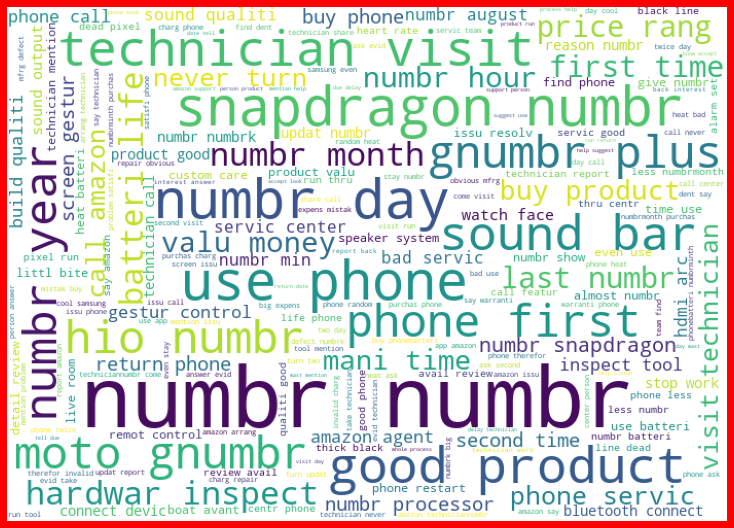

In [35]:
#Getting sense of words in Rating 1
one = df['Product_Review'][df['Ratings']==1]

one_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(one))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

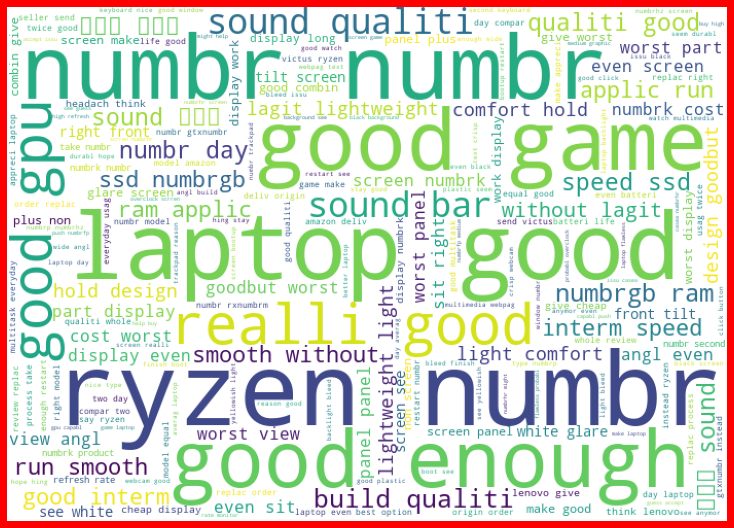

In [36]:
#Getting sense of words in Rating 2
one = df['Product_Review'][df['Ratings']==2]

one_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(one))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

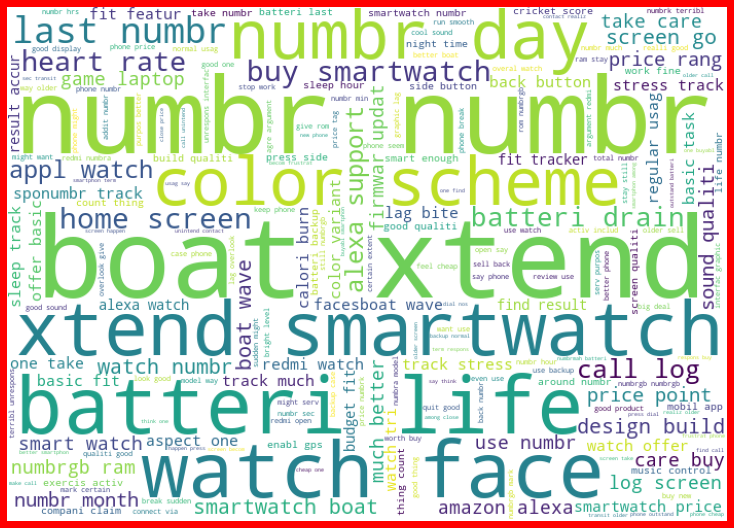

In [37]:
#Getting sense of words in Rating 3
one = df['Product_Review'][df['Ratings']==3]

one_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(one))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

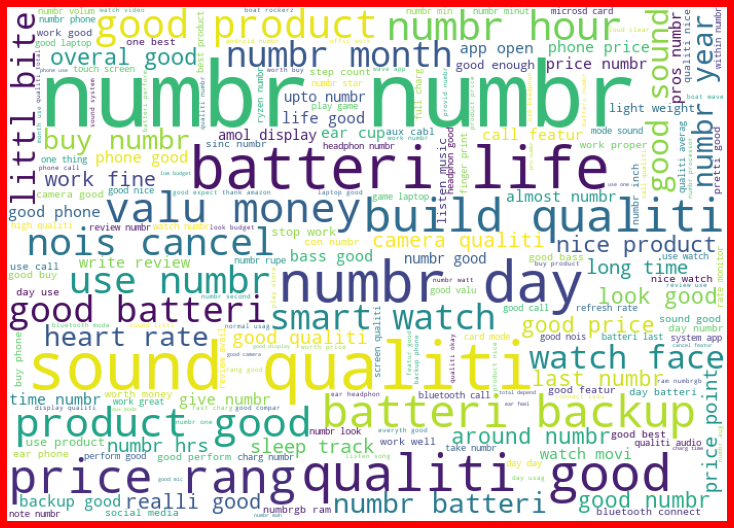

In [38]:
#Getting sense of words in Rating 4
one = df['Product_Review'][df['Ratings']==4]

one_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(one))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

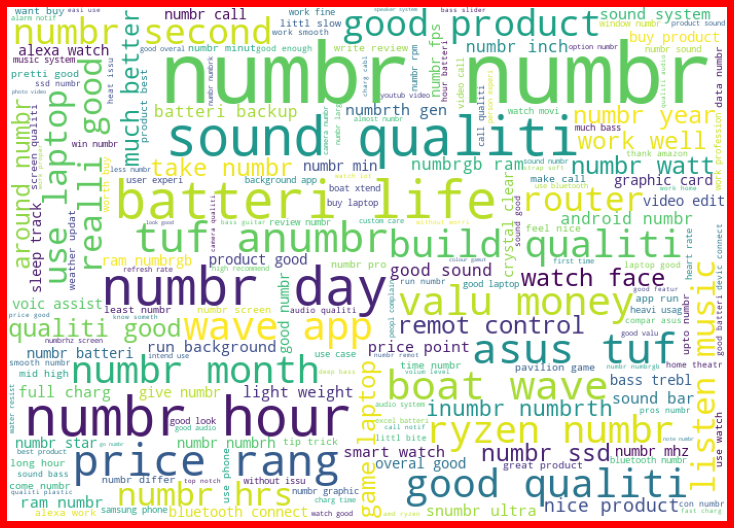

In [39]:
#Getting sense of words in Rating 5
one = df['Product_Review'][df['Ratings']==5]

one_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(one))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [40]:
# 1. Convert text into vectors using TF-IDF
# 3. Split feature and label

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tf_vec = TfidfVectorizer()
features = tf_vec.fit_transform(df['Product_Review'])

X = features
y = df['Ratings']
X.shape

(64410, 6307)

In [41]:
y.shape

(64410,)

In [75]:
df

,Product_Review,Ratings,clean_review
0,buy headphon seller deliv refurbish alreadi us...,4.0,"[buy, headphon, seller, deliv, refurbish, alre..."
1,इसक saund qualiti camfort water resist nois ca...,4.0,"[इसक, saund, qualiti, camfort, water, resist, ..."
2,review avail,4.0,"[review, avail]"
3,amaz pair headphon get numbr worth price excep...,4.0,"[amaz, pair, headphon, get, numbr, worth, pric..."
4,realli like headphon great valu price quantiti...,4.0,"[realli, like, headphon, great, valu, price, q..."
...,...,...,...
64405,serv purpos normal offic work gamer cannot com...,5.0,"[serv, purpos, normal, offic, work, gamer, can..."
64406,nice one money,5.0,"[nice, one, money]"
64407,good product worthi,5.0,"[good, product, worthi]"
64408,product good warranti card give unfil,5.0,"[product, good, warranti, card, give, unfil]"


In [81]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cols = ['Product_Review','Ratings']
df[cols]=df[cols].apply(LabelEncoder().fit_transform)

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['float', 'str']

In [82]:
# Libraries for training

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

# Ensemble Techniques

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model selection libraries
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV

# Mmetrics to evaluate our model performance 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
# Creating instances

RF=RandomForestClassifier()
MNB=MultinomialNB()
DT=DecisionTreeClassifier()
AD=AdaBoostClassifier()
XG=XGBClassifier()

In [83]:
# List of Models
models=[]
models.append(('MultinomialNB()',MNB))
models.append(('DecisionTreeClassifier',DT))
models.append(('RandomForestClassifier',RF))
models.append(('AdaBoostClassifier',AD))
models.append(('XGBClassifier',XG))

In [84]:
# Finding best Random State and then calculate Maximum Accuracy Score
def max_acc_score(clf,x,y):
    max_acc_score=0
    final_r_state=0
    for r_state in range(42,100):
        x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=.30,random_state=r_state,stratify=y)
        clf.fit(x_train,y_train)
        y_pred=clf.predict(x_test)
        acc_score=accuracy_score(y_test,y_pred)
        if acc_score < max_acc_score:
            max_acc_score=acc_score
            final_r_state=r_state
    print('Max Accuracy Score corresponding to Random State ', final_r_state, 'is:', max_acc_score)
    print('\n')
    return final_r_state

In [85]:
df.dtypes

Product_Review    object
Ratings           object
clean_review      object
dtype: object

In [ ]:
Model=[]
Score=[]
Acc_score=[]

#            For Loop to Calculate Accuracy Score, Cross Val Score, Classification Report, Confusion Matrix

for name,model in models:
    print('***************************',name,'*****************************')
    print('\n')
    Model.append(name)
    print(model)
    print('\n')
    
     #        Now here I am calling a function which will calculate the max accuracy score for each model 
     #                               and return best random state.
    r_state=max_acc_score(model,X,y)
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=r_state,stratify=y)
    model.fit(x_train,y_train)
#..............Learning Score...........
    score=model.score(x_train,y_train)
    print('Learning Score : ',score)
    Score.append(score*100)
    y_pred=model.predict(x_test)
    acc_score=accuracy_score(y_test,y_pred)
    print('Accuracy Score : ',acc_score)
    Acc_score.append(acc_score*100)

#................Classification Report...........................      
    print('Classification Report:\n',classification_report(y_test,y_pred))
    print('\n')
    
    print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
    print('\n')

In [88]:
X_train,x_test,Y_train,y_test=train_test_split(X,y,random_state=42,)

In [92]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

In [ ]:
X_train,x_test,Y_train,y_test=train_test_split(X,y,random_state=42,)

dt=DecisionTreeClassifier()

kn=KNeighborsClassifier()
mn=MultinomialNB()

list=[dt,kn,mn]

print(dt)
get_score(dt)

# Final Model

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=70,test_size=.30,stratify=y)
clf_rf = RandomForestClassifier(max_depth = 30,     n_estimators = 500, min_samples_split = 2, min_samples_leaf = 1)
clf_rf.fit(x_train,y_train)
clf_rf.score(x_train,y_train)
RFpred=clf_rf.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,RFpred)) 
print('Confusion Matrix:\n',confusion_matrix(y_test,RFpred))
print('Classification Report:','\n',classification_report(y_test,RFpred))